In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

## Download dos dados

In [9]:
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2021, 1, 1)
stock = 'AAPL'

ma_period = 60
period = 14

In [7]:
ticker = yf.download(stock, start_date, end_date)
data = pd.DataFrame(ticker)

[*********************100%***********************]  1 of 1 completed


In [8]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.135757,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.128590,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.319626,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.790062,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.634850,82271200
...,...,...,...,...,...,...
2020-12-24,131.320007,133.460007,131.100006,131.970001,130.994522,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.679642,124486200
2020-12-29,138.050003,138.789993,134.339996,134.869995,133.873077,121047300


## Construção dos sinais

In [20]:
# média móvel
data['SMA'] = data['Close'].rolling(window=ma_period).mean()

# tendência
data['trend'] = (data['Open'] - data['SMA']) * 100

# Relative Strength Indicator
data['move'] = data['Close'] - data['Close'].shift(1)
data['up'] = np.where(data['move'] > 0, data['move'], 0)
data['down'] = np.where(data['move'] < 0, data['move'], 0)
data['average_gain'] = data['up'].rolling(period).mean()
data['average_loss'] = data['down'].abs().rolling(period).mean()
data['relative_strength'] = data['average_gain'] / data['average_loss']
rsi = 100.0 - (100.0 / (1.0 + data['relative_strength']))
data['RSI'] = rsi / 100 # features with same order

# Average True Range
high_low = data['High'] - data['Low']
high_close = np.abs(data['High'] - data['Close'].shift())
low_close = np.abs(data['Low'] - data['Close'].shift())

ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_ranges = np.max(ranges, axis=1)

data['ATR'] = true_ranges.rolling(14).mean() # true_ranges.rolling(14).sum() / 14

# Boillinger Bands
data['tp'] = (data['Close'] + data['Low'] + data['High']) / 3
data['std'] = data['tp'].rolling(20).std()
data['ma'] = data['tp'].rolling(20).mean()
data['upper_band'] = data['ma'] + 2 * data['std']
data['lower_band'] = data['ma'] - 2 * data['std']

data['boillinger'] = np.where(data['Close']  > data['upper_band'], 1, -1)

# Crossover Strategy
data['short_ma'] = data['Close'].ewm(span=30).mean()
data['long_ma'] = data['Close'].ewm(span=50).mean()
data['crossover'] = np.where(data['short_ma']  > data['long_ma'], 1, -1)

# variável de saída - subida = 1, descida = -1
data['direction'] = np.where(data['Close'] - data['Open'] > 0, 1, -1)

# remoção dos valores nan
currency_data = data.dropna()

In [19]:
currency_data

,Open,High,Low,Close,Adj Close,Volume,SMA,trend,move,up,...,tp,std,ma,upper_band,lower_band,boillinger,short_ma,long_ma,crossover,direction
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-28,41.812500,42.505001,41.297501,41.619999,39.917580,166674000,43.066208,-125.370839,-0.465000,0.000000,...,41.807500,1.068830,43.771125,45.908786,41.633465,-1,43.212811,43.176270,1,-1
2018-03-29,41.952499,42.937500,41.724998,41.945000,40.229290,153594000,43.047542,-109.504236,0.325001,0.325001,...,42.202499,1.123427,43.683584,45.930438,41.436729,-1,43.129593,43.123377,1,-1
2018-04-02,41.660000,42.235001,41.117500,41.669998,39.965530,150347200,43.024417,-136.441689,-0.275002,0.000000,...,41.674166,1.209582,43.579959,45.999123,41.160794,-1,43.033894,43.061174,-1,1
2018-04-03,41.910000,42.187500,41.220001,42.097500,40.375542,121112000,43.005083,-109.508355,0.427502,0.427502,...,41.835000,1.263437,43.467209,45.994082,40.940335,-1,42.972563,43.020077,-1,1
2018-04-04,41.220001,43.002499,41.192501,42.902500,41.147617,138422000,42.990958,-177.095718,0.805000,0.805000,...,42.365833,1.272060,43.372792,45.916913,40.828671,-1,42.967979,43.015080,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,131.320007,133.460007,131.100006,131.970001,130.994522,54930100,119.333833,1198.617388,1.009995,1.009995,...,132.176671,4.193376,124.751833,133.138585,116.365082,-1,123.708966,121.116474,1,1
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.679642,124486200,119.665500,1432.450536,4.720001,4.720001,...,135.846664,4.444000,125.705833,134.593834,116.817833,1,124.546453,121.727201,1,1
2020-12-29,138.050003,138.789993,134.339996,134.869995,133.873077,121047300,120.029667,1802.033628,-1.820007,0.000000,...,135.999995,4.706801,126.558666,135.972268,117.145065,-1,125.212488,122.242604,1,-1


## Machine learning - Support Vector Machine

In [14]:
X = currency_data[['trend', 'RSI', 'ATR', 'boillinger', 'crossover']]
y = currency_data['direction']

In [22]:
# separação dos dados em teste e treino (30% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [23]:
# grid search para encontrar os melhores hiperparâmetros do modelo SVC
parameters = {'gamma': [10, 1, 0.1, 0.01, 0.001],
             'C': [1, 10, 100, 1000, 10000]}
grid = list(ParameterGrid(parameters))

best_accuracy = 0
best_parameter = None

for p in grid:
    model = SVC(C=p['C'], gamma=p['gamma'])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print('Acurácia do modelo: %.4f' % accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_parameter = p

print('Melhores hiperparâmetros')
print(best_accuracy)
print(best_parameter)

Acurácia do modelo: 0.5476
Acurácia do modelo: 0.5333
Acurácia do modelo: 0.5143
Acurácia do modelo: 0.5190
Acurácia do modelo: 0.5476
Acurácia do modelo: 0.5429
Acurácia do modelo: 0.5476
Acurácia do modelo: 0.4952
Acurácia do modelo: 0.5143
Acurácia do modelo: 0.5476
Acurácia do modelo: 0.5429
Acurácia do modelo: 0.5476
Acurácia do modelo: 0.4905
Acurácia do modelo: 0.5048
Acurácia do modelo: 0.5190
Acurácia do modelo: 0.5429
Acurácia do modelo: 0.5476
Acurácia do modelo: 0.4905
Acurácia do modelo: 0.5048
Acurácia do modelo: 0.5000
Acurácia do modelo: 0.5429
Acurácia do modelo: 0.5476
Acurácia do modelo: 0.5048
Acurácia do modelo: 0.5095
Acurácia do modelo: 0.4952
Melhores hiperparâmetros
0.5476190476190477
{'C': 1, 'gamma': 10}


In [8]:
model = SVC(C=best_parameter['C'], gamma=best_parameter['gamma'])
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('Acurácia do modelo: %.2f' % accuracy_score(y_test, predictions))
print(confusion_matrix(predictions, y_test))

Accuracy of the model: 0.54
[[  0   0]
 [ 96 114]]


In [24]:
# quantos valores temos de subida e descida
y.value_counts()

 1    384
-1    313
Name: direction, dtype: int64

<AxesSubplot:xlabel='Date'>

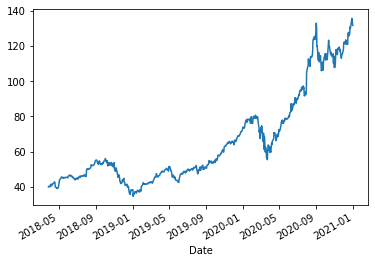

In [25]:
currency_data['Adj Close'].plot()

## Machine Learning - RandomForest

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
model = RandomForestClassifier()

In [13]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.580952380952381
